TV-Regularized Cone Beam CT for Symmetric Objects
=================================================

This example demonstrates a total variation (TV) regularized
reconstruction for cone beam CT of a cylindrically symmetric object,
by solving the problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is a single-view X-ray transform (with an implementation based
on a projector from the AXITOM package <cite data-cite="olufsen-2019-axitom"/>),
$\mathbf{y}$ is the measured data, $C$ is a 2D finite difference
operator, and $\mathbf{x}$ is the solution.

In [1]:
import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.xray.symcone import SymConeXRayTransform
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement.

In [3]:
A = SymConeXRayTransform(x_gt.shape, 5e2 * N, 6e2 * N)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)

Compute FDK reconstruction.

In [4]:
x_inv = A.fdk(y)

Set up the problem to be solved. Anisotropic TV, which gives slightly
better performance than isotropic TV for this problem, is used here.

In [5]:
f = loss.SquaredL2Loss(y=y, A=A)
λ = 2.35e1  # ℓ1 norm regularization parameter
g = λ * functional.L1Norm()  # Note the use of anisotropic TV
C = linop.FiniteDifference(input_shape=x_gt.shape)

Set up ADMM solver object.

In [6]:
ρ = 1.03e2  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=snp.clip(x_inv, 0.0, 1.0),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0.0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.35e+00  5.417e+04  2.424e+02  5.400e+03     20  9.177e-05


  10  2.50e+00  6.184e+04  1.009e+01  1.181e+02      4  9.608e-05


  20  2.85e+00  6.245e+04  6.027e+00  3.595e+00      0  9.241e-05


  30  3.17e+00  6.283e+04  4.226e+00  2.732e+00      0  8.952e-05


  40  3.43e+00  6.320e+04  6.404e+00  6.062e+01      4  9.076e-05


  50  3.73e+00  6.313e+04  7.603e+00  4.556e+00      0  9.845e-05


  60  4.02e+00  6.329e+04  6.078e+00  2.687e+00      0  8.165e-05


  70  4.29e+00  6.323e+04  3.431e+00  1.871e+00      0  9.997e-05


  80  4.53e+00  6.329e+04  2.105e+00  1.042e+00      0  9.536e-05


  90  4.77e+00  6.332e+04  1.866e+00  1.270e+00      0  9.924e-05


  99  5.00e+00  6.336e+04  1.832e+00  7.016e+00      2  8.620e-05


Show results.

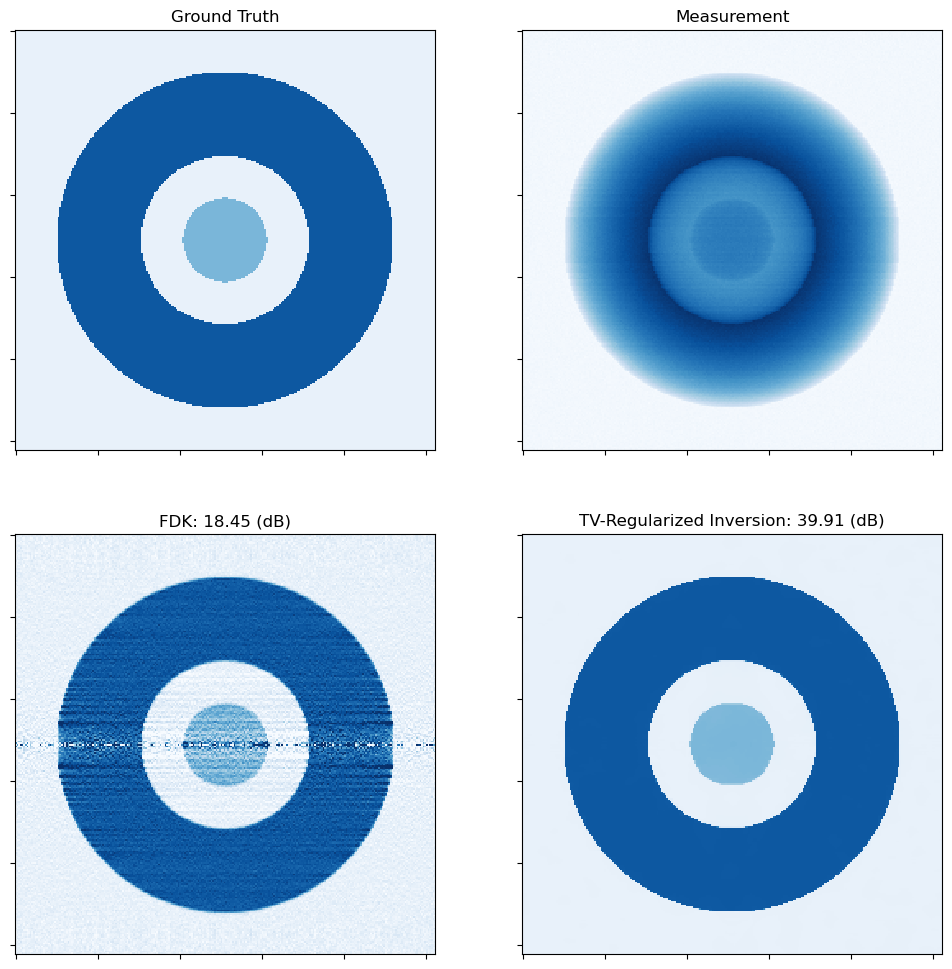

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="FDK: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV-Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()